In [1]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from openeo_gfmap.manager.job_splitters import (
    split_job_hex,
    split_job_s2grid,
    split_job_s2sphere,
)
import random

In [2]:
base_df_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/gfmap/DEMO_CROPTYPE.gpkg"
base_df = gpd.read_file(base_df_path)

max_points = 500

In [3]:
def plot_job_split(job_split):
    # Create a map centered around the mean coordinates of the geometries
    m_hex = folium.Map(location=[57, 25], zoom_start=8)

    # Define a list of colors to use for different GeoDataFrames
    # colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black']
    colors = [
        "#dd495a", "#0cb7be", "#f39ea4", "#6ec448", "#e0ad8c", "#8279cd", "#4467a3",
        "#dfcda7", "#30ec75", "#0d95ba", "#2486e3", "#761359", "#74bb6e", "#2d1086",
        "#791224", "#217fbe", "#aba52d", "#9100ff", "#f0ea20", "#71ca5f", "#9d39d9",
        "#638a73", "#00277b", "#443498", "#5db4a9", "#f25001", "#f6b4a6", "#24b7f2",
        "#c2d8a1", "#711868", "#437718", "#0c1fa8", "#34d604", "#f4ae7f", "#8a37d1",
        "#a5139a", "#d28100", "#450b32", "#3a774e", "#73affc"
    ]

    # Add each GeoDataFrame in job_split to the map with a different color
    for gdf in job_split:
        color = random.choice(colors)
        for _, row in gdf.iterrows():
            sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j, style_function=lambda x, color=color: {'color': color, 'weight': 10})
            folium.Popup(row['sample_id']).add_to(geo_j)
            geo_j.add_to(m_hex)

    # Display the map
    return m_hex

In [ ]:
# plot_job_split([base_df])

In [ ]:
hex_split_4 = split_job_hex(base_df, max_points=max_points, grid_resolution=4)

# plot_job_split(hex_split_4)

In [ ]:
hex_split_3 = split_job_hex(base_df, max_points=max_points, grid_resolution=3)

# plot_job_split(hex_split_3)

In [ ]:
s2grid_split = split_job_s2grid(base_df, max_points=max_points, web_mercator=True)

# plot_job_split(s2grid_split)

In [ ]:
s2sphere_split = split_job_s2sphere(base_df, max_points=max_points, start_level=5)

# plot_job_split(s2sphere_split)

All points in Latvija:

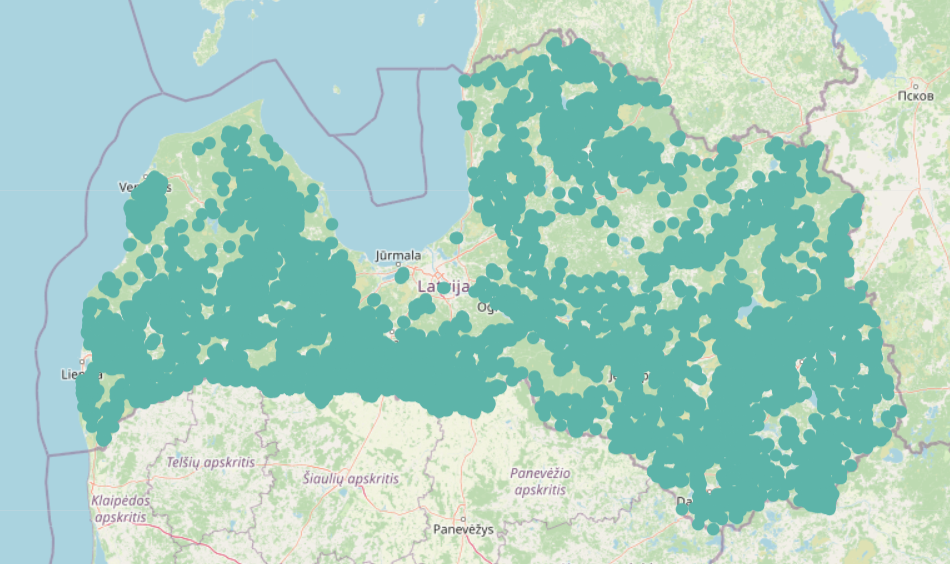

Job split hex with resolution 4:

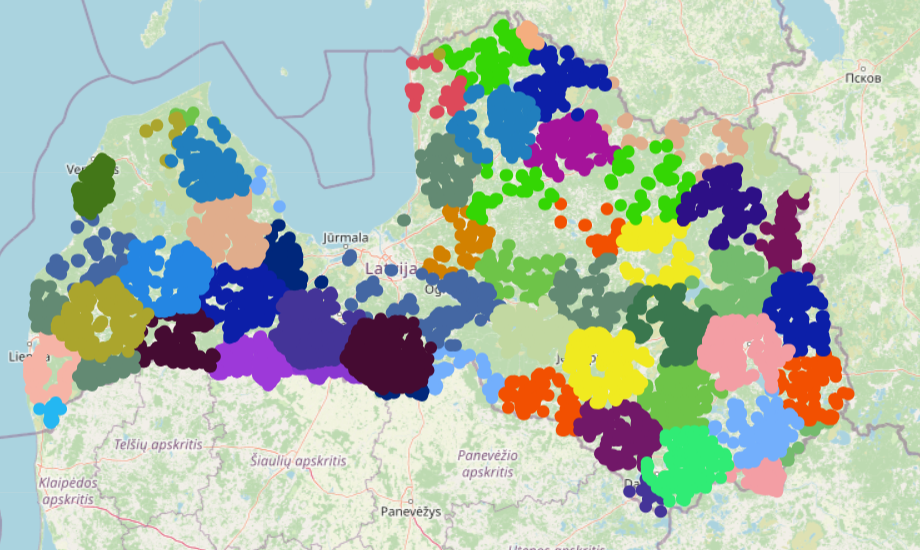

Job split hex with resolution 3:

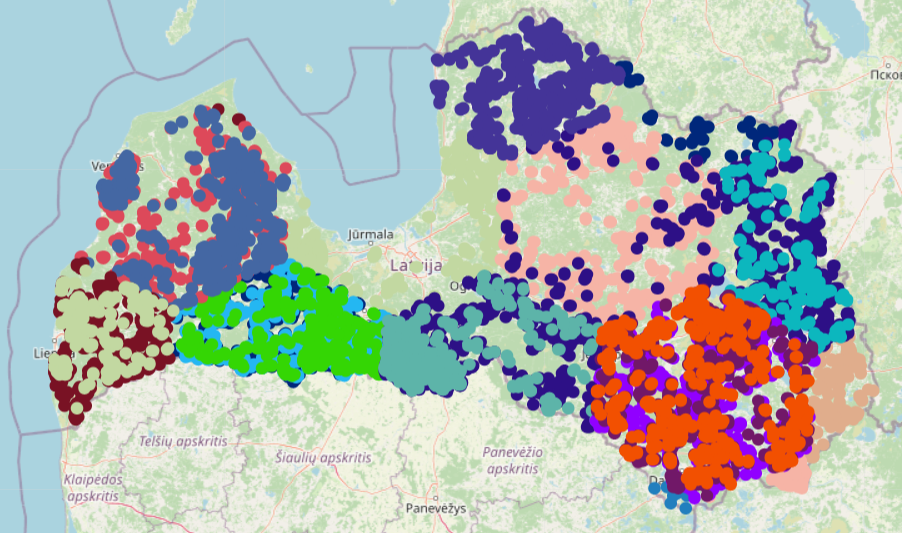

Job split Sentinel-2 grid:

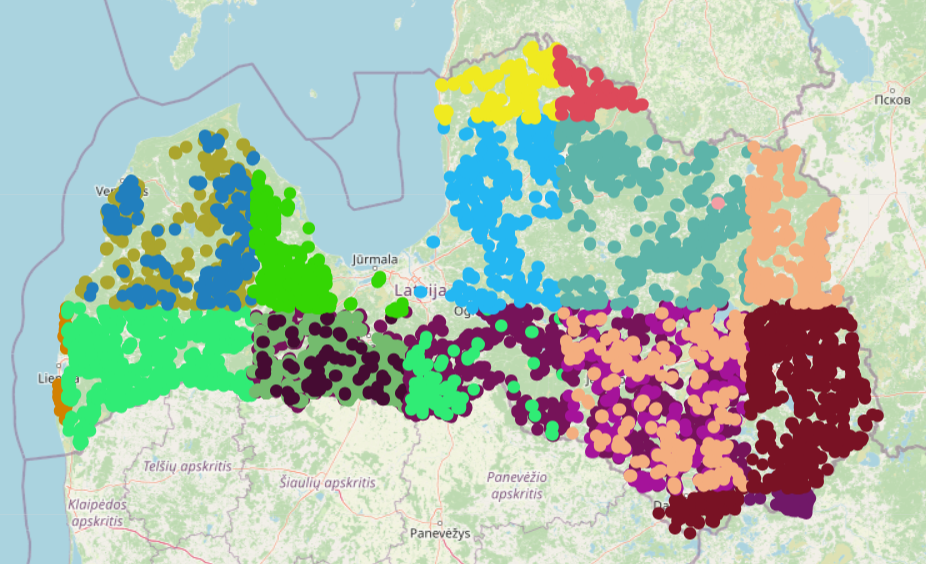

Job split S2sphere grid:

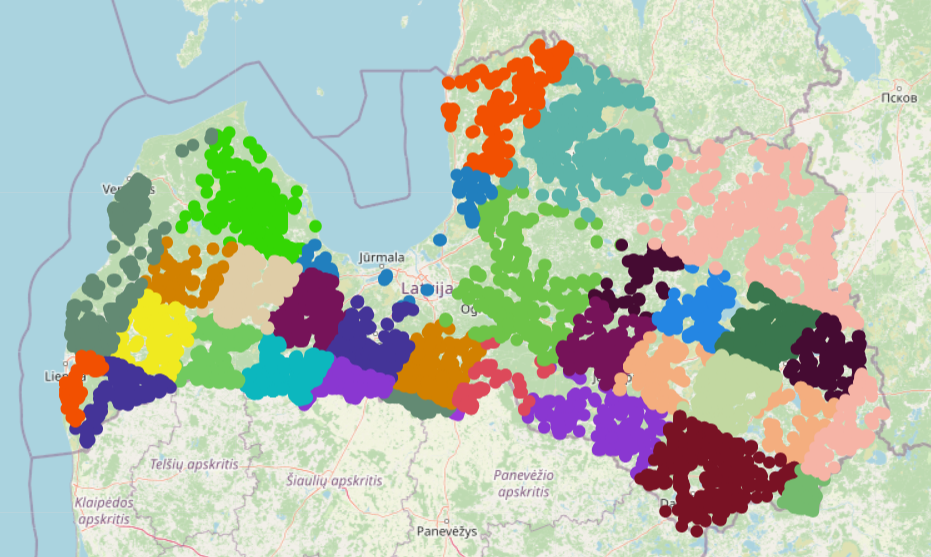

To recreate these images uncomment the `plot_job_split` function in the code above.

In [9]:
print(f"hex_split_4 resulted in {len(hex_split_4)} splits")
print(f"hex_split_3 resulted in {len(hex_split_3)} splits")
print(f"s2grid_split resulted in {len(s2grid_split)} splits")
print(f"s2sphere_split resulted in {len(s2sphere_split)} splits")

hex_split_4 resulted in 137 splits
hex_split_3 resulted in 53 splits
s2grid_split resulted in 55 splits
s2sphere_split resulted in 77 splits


## Area covered per job and overlapping areas

While they have a lot less jobs, both the Hex 3 split as the S2Grid split show that multiple jobs cover the same spatial extent. This is suboptimal as the same source data will need to be loaded in for both jobs. To get an upper-limit (as openEO is smart about which data to load in) we can compare the sum of the area's of the bounding boxes of the jobs for each job splitter:

In [11]:
def calculate_bounding_box_area(gdf):
    # Check if CRS is missing and set it to EPSG:4326
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)
    
    # Reproject to EPSG:3035
    gdf = gdf.to_crs(epsg=3035)
    
    # Calculate the bounding box
    bbox = gdf.total_bounds  # returns (minx, miny, maxx, maxy)
    
    # Calculate the area of the bounding box
    minx, miny, maxx, maxy = bbox
    area = (maxx - minx) * (maxy - miny)
    
    return area / 1_000_000  # Convert to km²

Sum of areas of bounding boxes for hex4_split: 143_067 km²
Sum of areas of bounding boxes for hex3_split: 359_939 km²
Sum of areas of bounding boxes for s2grid_split: 306_339 km²
Sum of areas of bounding boxes for s2sphere_split: 197_363 km²


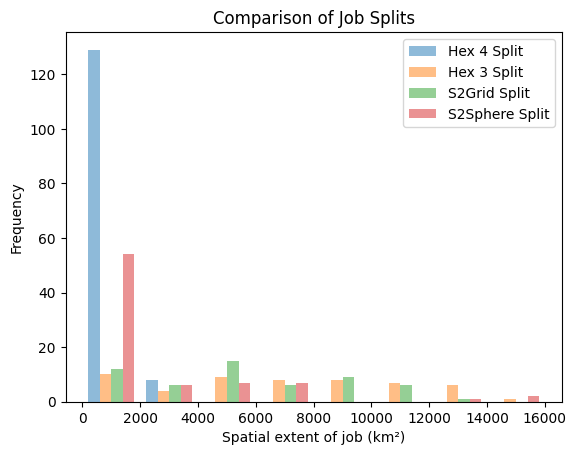

In [12]:
hex4_areas = [int(calculate_bounding_box_area(gdf)) for gdf in hex_split_4]
hex3_areas = [int(calculate_bounding_box_area(gdf)) for gdf in hex_split_3]
s2grid_areas = [int(calculate_bounding_box_area(gdf)) for gdf in s2grid_split]
s2sphere_areas = [int(calculate_bounding_box_area(gdf)) for gdf in s2sphere_split]

print(f"Sum of areas of bounding boxes for hex4_split: {sum(hex4_areas):_} km²")
print(f"Sum of areas of bounding boxes for hex3_split: {sum(hex3_areas):_} km²")
print(f"Sum of areas of bounding boxes for s2grid_split: {sum(s2grid_areas):_} km²")
print(f"Sum of areas of bounding boxes for s2sphere_split: {sum(s2sphere_areas):_} km²")

import numpy as np
bins = np.arange(min(hex4_areas + hex3_areas+ s2grid_areas + s2sphere_areas), max(hex4_areas + hex3_areas + s2grid_areas + s2sphere_areas) + 2000, 2000)


# Plot the histogram
plt.hist([hex4_areas, hex3_areas, s2grid_areas, s2sphere_areas], bins=bins, alpha=0.5, label=['Hex 4 Split', 'Hex 3 Split', 'S2Grid Split', 'S2Sphere Split'])

# Add labels and title
plt.xlabel('Spatial extent of job (km²)')
plt.ylabel('Frequency')
plt.title('Comparison of Job Splits')
plt.legend(loc='upper right')

# Show the plot

plt.show()

We see clearly that the S2Sphere and Hex 4 splits have a lot smaller spatial_extents than the Hex 3 and S2Grid splits. But more importantly the sum of all the area's of the bounding boxes of the jobs is a lot smaller for the S2Sphere and Hex 4 splits. This means that the S2Sphere and Hex 4 splits will have less overlapping data to load in than the Hex 3 and S2Grid splits.

## Number of points per job

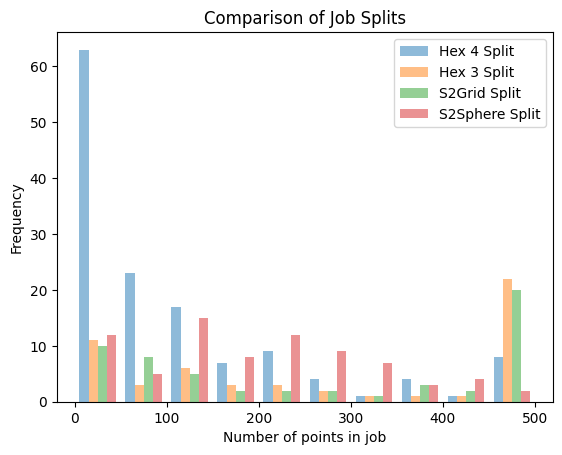

In [14]:
# Calculate the lengths of each gdf in the job splits
hex4_lengths = [len(gdf) for gdf in hex_split_4]
hex3_lengths = [len(gdf) for gdf in hex_split_3]
s2grid_lengths = [len(gdf) for gdf in s2grid_split]
s2sphere_lengths = [len(gdf) for gdf in s2sphere_split]

# Define the number of bins for the histogram
bins = range(0, max(max(hex4_lengths), max(hex3_lengths), max(s2grid_lengths), max(s2sphere_lengths)) + 50, 50)

# Plot the histogram
plt.hist([hex4_lengths, hex3_lengths, s2grid_lengths, s2sphere_lengths], bins=bins, alpha=0.5, label=['Hex 4 Split', "Hex 3 Split", 'S2Grid Split', 'S2Sphere Split'])

# Add labels and title
plt.xlabel('Number of points in job')
plt.ylabel('Frequency')
plt.title('Comparison of Job Splits')
plt.legend(loc='upper right')

# Show the plot
plt.show()

Comparing the number of points in each job, we notice that the hex 4 split contains a lot of jobs with a small number of points. This can be problematic as each job causes some constant overhead causing the cost per point to be higher.